In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2,3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2,3


In [2]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN, 
    one_hot_from_int, 
    truncated_noise_sample)
import time
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import numpy as np
import IPython.display
import cv2

In [3]:
G = BigGAN.from_pretrained('biggan-deep-256')

In [4]:
# Prepare a input
truncation = 0.4
class_vector = one_hot_from_int(207, batch_size=4)
noise_vector = truncated_noise_sample(truncation=truncation,
                                      batch_size=4, seed=1)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')
G.to('cuda')

# Generate an image
with torch.no_grad():
    output = G(noise_vector, class_vector, truncation)

image_grid = vutils.make_grid(
    output,
    nrow=len(noise_vector),
    normalize=True,
)

In [5]:
image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
image_grid_np = np.uint8(image_grid_np)
print("Image Grid Shape: {}".format(np.shape(image_grid_np)))
print("Max pixel value: {}".format(np.max(image_grid_np)))
print("Min pixel value: {}".format(np.min(image_grid_np)))

Image Grid Shape: (260, 1034, 3)
Max pixel value: 254
Min pixel value: 0


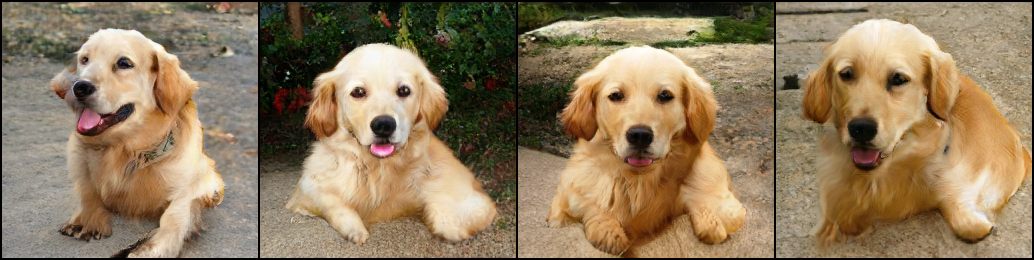

In [19]:
IPython.display.display(Image.fromarray(image_grid_np))

In [7]:
class ColorTransform:
  def __init__(self):
    self.Nsliders = 3
    self.num_channels = 3
  
  def get_target_np(self, outputs_zs, alpha):
    ''' return target image and mask '''
    outputs_zs = outputs_zs.transpose(0, 2, 3, 1)
    mask_out = np.ones(outputs_zs.shape)
    if not np.any(alpha): # alpha is all zeros
      return outputs_zs, mask_out, np.count_nonzero(mask_out)
    target_fn = np.copy(outputs_zs)
    for b in range(alpha.shape[0]):
      for i in range(self.num_channels):
        target_fn[b,:,:,i] = target_fn[b,:,:,i]+alpha[b,i]
    target_fn = target_fn.transpose(0, 3, 1, 2)
    mask_out = mask_out.transpose(0, 3, 1, 2)
    return target_fn, mask_out, np.count_nonzero(mask_out)

  def get_train_alpha(self, batch_size):
    ''' get an alpha for training, return in format
      alpha_val_for_graph, alpha_val_for get_target_np'''
    alpha_val = np.random.random(size=(batch_size, self.num_channels))-0.5
    # graph and target use the same slider value
    alpha_val_for_graph = alpha_val
    alpha_val_for_target = alpha_val
    return alpha_val_for_graph, alpha_val_for_target
   

  def scale_test_alpha_for_graph(self, alpha, batch_size, channel=None,
                   contrast=True):
    ''' map a scalar alpha to the appropriate shape,
      and do the desired transformation '''
    if channel is None:
      slider = alpha * np.ones((batch_size, self.num_channels))
    else:
      assert(channel >= 0)
      assert(channel < self.num_channels)
      if contrast: # contrast is good for vis
        slider = -alpha * np.ones((batch_size, self.Nsliders))
      else: # good for channel-specific effects
        slider = np.zeros((batch_size, self.Nsliders))
      slider[:, channel] = alpha
    return slider
  
  def vis_alphas(self, num_panels=7, alpha_min=0, alpha_max=1):
    return np.linspace(alpha_min, alpha_max, num_panels)

In [8]:
transform = ColorTransform()

In [ ]:
# training parameters
dim_z = truncated_noise_sample(truncation=0.1, batch_size=1).shape[1]
learning_rate = 0.001 # you can also try changing this as well

In [10]:
w = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z, transform.Nsliders]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)

In [11]:
# loss function and optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam([w], lr=learning_rate)

In [20]:
num_samples = 4
truncation = 1.0
loss_sum = 0;
optim_iter = 0
batch_size = 4
loss_values = []
save_freq = 100 # frequency to save weights

# train loop
for batch_num in range(num_samples // batch_size):
  start_time = time.time()
  
  # 1. sample z and y randomly
  z = truncated_noise_sample(truncation=truncation, batch_size=batch_size,
                             seed=None)
  y = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)

  z = torch.from_numpy(z).to('cuda')
  y = torch.from_numpy(y).to('cuda')

  # sample alpha
  alpha_for_graph, alpha_for_target = transform.get_train_alpha(batch_size)
  alpha_tensor = torch.tensor(alpha_for_graph, device='cuda', dtype=torch.float32)

  with torch.no_grad():
    # 2. do a forward pass to get model outputs: out_im
    out_im = G(z, y, truncation)

    
  # get target and mask
  target_fn, mask_out, numel_mask = transform.get_target_np(out_im.cpu().numpy(), alpha_for_target)
  target_tensor = torch.tensor(target_fn, device='cuda', dtype=torch.float32)
  mask_tensor = torch.tensor(mask_out, device='cuda', dtype=torch.float32)
  numel_mask_tensor = torch.tensor(numel_mask, device='cuda', dtype=torch.float32)
  
  # forward pass
  optimizer.zero_grad()
  z_new = z
  for i in range(transform.Nsliders):
    # 3. for each slider, add alpha * w to z_, you may need to check dimensions
    z_new = z_new + alpha_tensor[:,i].unsqueeze(1) * w[:,:,i]
    
  out_im = G(z_new, y, truncation)
  # mean over unmasked regions in the target
  loss = criterion(out_im * mask_tensor, target_tensor * mask_tensor) / numel_mask_tensor
  
  # 4. optimize loss 
  loss.backward()
  optimizer.step()
  
  loss_values.append(loss)
  loss_sum += loss
  elapsed_time = time.time() - start_time
  
  print('T, bst, lss, a: {}, {}, {}, {}'.format(
      elapsed_time, batch_num * batch_size, loss, alpha_for_target))
 
  # save intermediate walk
  if (optim_iter % save_freq == 0) and (optim_iter > 0):
    torch.save(w, 'w_{}.pth'.format(optim_iter * batch_size))
  
  optim_iter += 1
  
print('average loss with this metric: ', loss_sum/(optim_iter*batch_size))
torch.save({'walk': w}, 'w_final.pth')

T, bst, lss, a: 0.35768747329711914, 0, 0.09666112810373306, [[-0.29325528 -0.0750339   0.03254204]
 [-0.30052083  0.13485684 -0.41414655]
 [ 0.03219416  0.23227748  0.380947  ]
 [ 0.28420985 -0.07566636  0.20449698]]
average loss with this metric:  tensor(0.0242, device='cuda:0', grad_fn=<DivBackward0>)
